In [1]:
# package(s) related to time, space and id
import datetime, time
import os
import io
import functools
import logging
import pickle
import random
import math

# package(s) related to the simulation
import enum
import simpy
import scipy as sc
import math
import networkx as nx  
import numpy as np
import pandas as pd
import re
import yaml as yaml
import time
import bisect
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.tri as tri
import xarray as xr

from osgeo import gdal
from scipy import interpolate
from scipy.signal import correlate
from shapely.ops import transform,split,snap
from matplotlib.ticker import MaxNLocator
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

# OpenTNSim
from opentnsim import core
from opentnsim import plot
from opentnsim import model
from opentnsim import import_hydrodynamic_dataset
from opentnsim import vessel_traffic_service
from opentnsim import port
from opentnsim import lock
from opentnsim import vessel
from opentnsim import waterway
from opentnsim import output
from opentnsim import tidal_window_constructor
from opentnsim import rule_constructor
from opentnsim import regulations

# spatial libraries 
import shapely.geometry
from shapely.geometry import Point
import shapely.wkt
import pyproj
import folium
import datetime
import time as timepy

# package(s) for data handling
import requests

logging.basicConfig(level=logging.INFO)
logger = logging.getLogger()

# define the coorinate systemb
geod = pyproj.Geod(ellps="WGS84")

location_vessel_database = "Vessels/richtlijnen-vaarwegen-2017.csv"

In [2]:
wgs = pyproj.CRS('EPSG:4326')
utm = pyproj.CRS('EPSG:28992')
wgs_to_utm = pyproj.Transformer.from_crs(wgs,utm,always_xy=True).transform
utm_to_wgs = pyproj.Transformer.from_crs(utm,wgs,always_xy=True).transform

In [3]:
starting_hour = 1000/(60*60*4)
next_hours = np.arange(0.25,12.25,0.25)
hours = np.append(np.array([starting_hour]),next_hours)

In [4]:
Node = type('Site', (core.Identifiable, core.Log, core.Locatable, core.HasResource), {})
nodes = []
path = []
coords = []

for hour in reversed(hours):
    coords.append(transform(utm_to_wgs,Point(155000-hour*60*60*4,463000)))
for hour in hours:
    coords.append(transform(utm_to_wgs,Point(155000+hour*60*60*4,463000)))

for index,coord in enumerate(coords):
    data_node = {"env": [],
                 "name": "Node_" + str(index+1),
                 "geometry": coord}
    node = Node(**data_node)
    nodes.append(node)
    
for i in range(len(nodes)-1):
    path.append([nodes[i],nodes[i+1]]) 
    path.append([nodes[i+1],nodes[i]])

FG = nx.MultiDiGraph()

positions = {}
for node in nodes:
    positions[node.name] = (node.geometry.x, node.geometry.y)
    FG.add_node(node.name, geometry = node.geometry)

for edge in path:
    geometry = shapely.geometry.LineString([FG.nodes[edge[0].name]['geometry'],FG.nodes[edge[1].name]['geometry']])
    FG.add_edge(edge[0].name, edge[1].name, weight = 1, Info = {},geometry=geometry)
    
for node in FG.nodes:
    FG.nodes[node]['Info'] = {}

In [5]:
for node in FG.nodes:
    FG.nodes[node]['geometry'] = transform(wgs_to_utm,FG.nodes[node]['geometry'])
    
for edge in FG.edges:
    geometry = transform(wgs_to_utm,FG.edges[edge]['geometry'])
    length = int(geometry.length)
    FG.edges[edge]['geometry'] = geometry
    FG.edges[edge]['Info']['geometry'] = geometry
    FG.edges[edge]['Info']['length'] = length

In [6]:
import pytz
simulation_start = datetime.datetime(2019,1,1,0,0,0)
duration = datetime.timedelta(seconds=14*24*60*60) #seconds

In [7]:
water_level = []
salinity = []

for nodes in enumerate(FG.nodes):
    water_level.append([[],[]])
    salinity.append([[],[]])

MBL = [11]*len(FG.nodes)
depth = MBL
times = np.arange(simulation_start,simulation_start+duration,datetime.timedelta(seconds=10*60))
stations = list(FG.nodes)

sea = True
for index,node in enumerate(list(FG.nodes)):
    if sea:
        water_level[index]=[1.0*np.sin(2*np.pi*((t-np.datetime64(0,'s'))/np.timedelta64(1, 's')-simulation_start.timestamp())/45000) for t in times]
        salinity[index]=[25.0 for t in times]
        if node == 'Node_49':
            sea = False
    else:
        water_level[index]=[0.0 for t in times]
        salinity[index]=[0.0 for t in times]

In [8]:
import xarray as xr
station_data = xr.DataArray(data=stations,
                         dims=["STATIONS"])

time_data = xr.DataArray(data=times,
                         dims=["TIME"])

MBL_data = xr.DataArray(data=MBL,
                        dims=["STATIONS"])

depth_data = xr.DataArray(data=depth,
                          dims=["STATIONS"])

water_level_data = xr.DataArray(data=[wlev for wlev in water_level],
                                dims=["STATIONS","TIME"])

salinity_data = xr.DataArray(data=[sal for sal in salinity],
                             dims=["STATIONS","TIME"])

hydrodynamic_data = xr.Dataset({'TIME':times,
                                'Stations':station_data,
                                'MBL':MBL_data,
                                'Depth':depth_data,
                                'Water level': water_level_data,
                                'Salinity':salinity_data})

C:\Users\floorbakker\AppData\Local\Temp\ipykernel_23280\3095883058.py:5: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.

C:\Users\floorbakker\AppData\Local\Temp\ipykernel_23280\3095883058.py:20: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by con

In [9]:
sim = model.Simulation(graph=FG,simulation_start=simulation_start,simulation_duration=duration,hydrodynamic_data=hydrodynamic_data)
env = sim.environment

In [10]:
sim.environment.vessel_traffic_service

In [11]:
lock_1 = lock.IsLock(env = sim.environment, 
                     name = 'Lock',
                     distance_doors1_from_first_waiting_area=750,   
                     distance_doors2_from_second_waiting_area=FG.edges['Node_49','Node_50',0]['Info']['length']-1250,
                     node_doors1 = 'Node_49', node_doors2 = 'Node_50',time_step=5,
                     lock_length = 500, lock_width = 40, lock_depth = 10.5, 
                     doors_open = 600, doors_close = 600, disch_coeff = 0.8,
                     opening_area = 4.0, opening_depth = 5.0,node_open='Node_50',
                     detector_nodes=[], priority_rules = regulations.ConditionalRule('start_node','==','Node_50'))

lineup_area_1 = lock.IsLockLineUpArea(env = sim.environment, name = 'Lock', distance_to_lock_doors = 100,
                                      start_node = 'Node_49',end_node = 'Node_50', lineup_length = 500)

lineup_area_2 = lock.IsLockLineUpArea(env = sim.environment, name = "Lock", distance_to_lock_doors = 100,
                                      start_node = 'Node_50',end_node = 'Node_49', lineup_length = 500)

waiting_area_1 = lock.IsLockWaitingArea(env = sim.environment, name = 'Lock', distance_from_node=0,
                                        node = 'Node_49')
    
waiting_area_2 = lock.IsLockWaitingArea(env = sim.environment, name = "Lock", distance_from_node=0,
                                        node = 'Node_50')

c:\users\floorbakker\opentnsim\opentnsim\lock.py:358: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



In [13]:
Vessel = type('Vessel', 
              (core.SimpyObject, core.Identifiable, lock.HasWaitingArea, lock.HasLock, lock.HasLineUpArea, core.Movable, vessel.VesselProperties, output.HasOutput, vessel.ExtraMetadata), {})

In [14]:
def create_vessel(name,FG,origin,destination,length,beam,draught,height,v,arrival_time):
    vessel_input = { "name":name,
                     "geometry":FG.nodes[origin]['geometry'],
                     "origin":origin,
                     "destination":destination,
                     #"next_destination":next_destination,
                     "route":nx.dijkstra_path(FG,origin,destination),
                     "env":env,
                     "type":'Tanker',
                     "B":beam,
                     "L":length,
                     "T": draught,
                     "H":height,
                     #"t_berthing":berthing_time.total_seconds(),
                     #"t_(un)loading":[time.total_seconds() for time in unloading_time],
                     #"t_turning":[time.total_seconds() for time in turning_time],
                     #"ukc":ukc,
                     "v":v,
                     #"terminal_of_call": terminal_of_call,
                     #"berth_of_call": berth_of_call,
                     #"(un)loading": delta_draught,
                     #"max_waiting_time":datetime.timedelta(days=10).total_seconds(),
                     #"max_cross_current":max_cross_current,
                     "arrival_time":arrival_time,
                     #"arrival_delay":arrival_time,
                     #"priority": 0,
                     #"additional_waiting_time": additional_waiting_time/np.timedelta64(1, 's'),
                     #"bound":bound,
                     #"priority":False
                   }
    return vessel_input

In [15]:
arrival_time = sim.environment.simulation_start
created_vessel = Vessel(**create_vessel(name = f'inbound_vessel_0',
                                        FG = FG,
                                        origin='Node_49',
                                        destination='Node_50',
                                        length=200,
                                        beam=35,
                                        draught=10,
                                        height=5,
                                        v=4,
                                        arrival_time=arrival_time))
sim.add_vessels(vessel=created_vessel)

arrival_time = sim.environment.simulation_start + pd.Timedelta(30,'min')
created_vessel = Vessel(**create_vessel(name = f'outbound_vessel_0',
                                        FG = FG,
                                        origin='Node_50',
                                        destination='Node_49',
                                        length=200,
                                        beam=35,
                                        draught=10,
                                        height=5,
                                        v=4,
                                        arrival_time=arrival_time))
sim.add_vessels(vessel=created_vessel)

In [16]:
waiting_area_1.resource.users

[]

In [17]:
t1 = timepy.time()
sim.run()
t2 = timepy.time()
print(t2-t1)

haiii inbound_vessel_0
haiii inbound_vessel_0
inbound_vessel_0 start waiting time 2019-01-01 00:02:50.833333
he ho o yo inbound_vessel_0
inbound_vessel_0 lock position given 2019-01-01 00:02:50.833333
inbound_vessel_0 requested place in next lockage 2019-01-01 00:02:50.833333
claim the lock doors inbound_vessel_0 2019-01-01 00:02:50.833333
approach node != node open
else: claiming lock: priority doors2 not -1 inbound_vessel_0 2019-01-01 00:02:50.833333 0
requested first set of doors inbound_vessel_0 2019-01-01 00:02:50.833333
lock doors claimed, empty conversion requested inbound_vessel_0 2019-01-01 00:02:50.833333
empty conversion requested inbound_vessel_0 2019-01-01 00:02:50.833333
hi 2019-01-01 00:02:50.833333
2019-01-01 00:02:50.833333 Node_50 Node_49 Lock doors closing start


c:\users\floorbakker\opentnsim\opentnsim\lock.py:547: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.

c:\users\floorbakker\opentnsim\opentnsim\lock.py:745: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precis

haiii outbound_vessel_0
haiii outbound_vessel_0
outbound_vessel_0 start waiting time 2019-01-01 00:32:50.833333
he ho o yo outbound_vessel_0
outbound_vessel_0 lock position given 2019-01-01 00:32:50.833333
outbound_vessel_0 requested place in next lockage 2019-01-01 00:32:50.833333
claim the lock doors outbound_vessel_0 2019-01-01 00:32:50.833333
approach node != node open
requesting approach: else outbound_vessel_0 2019-01-01 00:32:50.833333 0 ['inbound_vessel_0'] ['inbound_vessel_0']
empty conversion done inbound_vessel_0 2019-01-01 00:47:25.833333
waiting done inbound_vessel_0 2019-01-01 00:47:25.833333
inbound_vessel_0 sail to assigned lock position
print doors inbound_vessel_0 ['inbound_vessel_0'] ['inbound_vessel_0']
left doors1 inbound_vessel_0 2019-01-01 00:58:32.500000 [] 1 ['inbound_vessel_0']
inbound_vessel_0 in lock ['inbound_vessel_0']
inbound_vessel_0 converting hap 2019-01-01 00:58:32.500000
hi 2019-01-01 00:58:32.500000
2019-01-01 00:58:32.500000 Node_49 Node_50 Lock do

c:\users\floorbakker\opentnsim\opentnsim\lock.py:745: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



inbound_vessel_0 hap is geconvert 2019-01-01 01:52:27.500000
left lock inbound_vessel_0 2019-01-01 01:52:27.500000
200 give back
500 back
left doors2 inbound_vessel_0 2019-01-01 01:56:48.611111 1 [] []
doors requested outbound_vessel_0
claiming lock: priority doors2 not -1 outbound_vessel_0 2019-01-01 01:56:48.611111
waiting done outbound_vessel_0 2019-01-01 01:56:48.611111
outbound_vessel_0 sail to assigned lock position
print doors outbound_vessel_0 ['outbound_vessel_0'] ['outbound_vessel_0']
left doors1 outbound_vessel_0 2019-01-01 02:07:55.277778 0 [] ['outbound_vessel_0']
outbound_vessel_0 in lock ['outbound_vessel_0']
outbound_vessel_0 converting hap 2019-01-01 02:07:55.277778
hi 2019-01-01 02:07:55.277778
2019-01-01 02:07:55.277778 Node_50 Node_49 Lock doors closing start


c:\users\floorbakker\opentnsim\opentnsim\lock.py:745: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



outbound_vessel_0 hap is geconvert 2019-01-01 03:04:30.277778
left lock outbound_vessel_0 2019-01-01 03:04:30.277778
200 give back
500 back
left doors2 outbound_vessel_0 2019-01-01 03:08:51.388889 0 [] []
38.28345847129822


In [18]:
sim.environment.run(sim.environment.process(lock_1.convert_chamber(sim.environment,'Node_50',0,sim.environment.vessels[0])))

hi 2019-01-15 00:00:00
2019-01-15 00:00:00 Node_49 Node_50 Lock doors closing start


c:\users\floorbakker\opentnsim\opentnsim\lock.py:547: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



In [19]:
lock_df = pd.DataFrame(lock_1.log)
lock_df.tail(n=16)

,Time,Location,Action,Status
8,2019-01-01 01:08:32.500000,Node_49,Lock chamber converting start,{}
9,2019-01-01 01:42:27.500000,Node_50,Lock chamber converting stop,{}
10,2019-01-01 01:42:27.500000,Node_50,Lock doors opening start,{}
11,2019-01-01 01:52:27.500000,Node_50,Lock doors opening stop,{}
12,2019-01-01 02:07:55.277778,Node_50,Lock doors closing start,{}
13,2019-01-01 02:17:55.277778,Node_50,Lock doors closing stop,{}
14,2019-01-01 02:17:55.277778,Node_50,Lock chamber converting start,{}
15,2019-01-01 02:54:30.277778,Node_49,Lock chamber converting stop,{}
16,2019-01-01 02:54:30.277778,Node_49,Lock doors opening start,{}
17,2019-01-01 03:04:30.277778,Node_49,Lock doors opening stop,{}


In [20]:
vessels = sim.environment.vessels

In [21]:
times = []
distances = []
positions = []

for _vessel_ in vessels:
    sailed_edges = []
    for edge in zip(_vessel_.route[:-1],_vessel_.route[1:]):
        sailed_edges.append(_vessel_.env.FG.edges[edge[0],edge[1],0]['geometry'])

    for loc,geom in enumerate(sailed_edges):
        if loc:
            multi_line = shapely.geometry.MultiLineString([final_geometry, geom])
            final_geometry = shapely.ops.linemerge(multi_line)
        else:
            final_geometry = geom
            
    vessel_time = []
    vessel_locations = []
    for loc,message in pd.DataFrame(_vessel_.log).iterrows():
        vessel_time.append(message.Time)
        vessel_locations.append(message.Location)
    
    vessel_distance = []
    for loc,location in enumerate(vessel_locations):
        if not loc:
            vessel_distance.append(0)
            continue
            
        geometries = split(snap(final_geometry, location, tolerance=100), location).geoms
        if len(geometries) > 1:
            vessel_distance.append(geometries[0].length)
        else:
            if loc >= len(vessel_locations)-2:
                vessel_distance.append(geometries[0].length)
            else:
                vessel_distance.append(vessel_distance[-1])
    
    if _vessel_.route[0] == 'Node_50':
        vessel_distance = [final_geometry.length-distance for distance in vessel_distance]
        
    times.append(vessel_time)
    distances.append(vessel_distance)
    positions.append(vessel_locations)

[<__main__.Vessel object at 0x000001A8CDBF4DC0>, <__main__.Vessel object at 0x000001A8CDBB7760>]
Node_49
Node_50


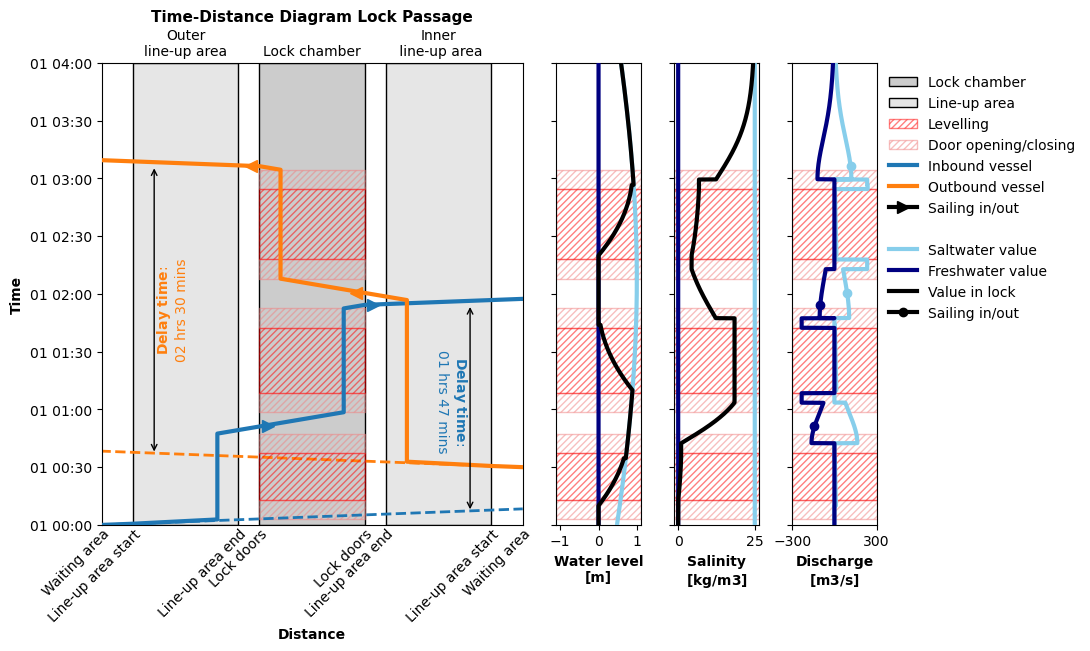

In [25]:
delays = True
entering_leaving = True

distance_to_lock_edge_start = 0#lock_1.env.vessel_traffic_service.provide_sailing_distance_over_route(vessels[0],nx.dijkstra_path(FG,'Node_1','Node_49'))['Distance'].sum()
distance_to_lock_edge_end = 2000#lock_1.env.vessel_traffic_service.provide_sailing_distance_over_route(vessels[0],nx.dijkstra_path(FG,'Node_1','Node_50'))['Distance'].sum()
lock_outer_doors = distance_to_lock_edge_start+lock_1.distance_doors1_from_first_waiting_area
lock_inner_doors = distance_to_lock_edge_end-lock_1.distance_doors1_from_first_waiting_area
lineup_1_start = lock_outer_doors - lineup_area_1.distance_to_lock_doors - lineup_area_1.lineup_length
lineup_1_end = lock_outer_doors - lineup_area_1.distance_to_lock_doors
lineup_2_start = lock_inner_doors + lineup_area_2.distance_to_lock_doors + lineup_area_2.lineup_length
lineup_2_end = lock_inner_doors + lineup_area_2.distance_to_lock_doors

fig,axes = plt.subplots(1,4,figsize=[10,6],gridspec_kw = {'width_ratios':[5,1,1,1]})
ax = axes[0]
for time,distance in zip(times,distances):
    ax.plot(distance,time,linewidth=3,zorder=3)
vessel1, = ax.plot([-1,-1],color='C0',linewidth=3)
vessel2, = ax.plot([-1,-1],color='C1',linewidth=3)
print(vessels)
for _vessel_ in vessels:
    vessel_df = pd.DataFrame(_vessel_.log)
    arrival_time = datetime.datetime.fromtimestamp(_vessel_.arrival_time)
    print(_vessel_.route[0])
    if _vessel_.route[0] == 'Node_50':
        sail_in_time_vessel_2 = pd.DataFrame(_vessel_.log).loc[_vessel_.log['Action'].index('Sailing to first set of lock doors stop')].Time
        sail_out_time_vessel_2 = pd.DataFrame(_vessel_.log).loc[_vessel_.log['Action'].index('Sailing to second set of lock doors stop')].Time
        if entering_leaving:
            ax.plot(lock_inner_doors-40,sail_in_time_vessel_2+pd.Timedelta(40/4,'s'),'C1',marker='<',markersize=8)
            ax.plot(lock_outer_doors-40,sail_out_time_vessel_2+pd.Timedelta(40/4,'s'),'C1',marker='<',markersize=8)
        if delays:
            ax.plot([final_geometry.length,0],[arrival_time,arrival_time+pd.Timedelta(int(final_geometry.length/4),'s')],color='C1',linestyle='--',linewidth=2)
            passage_lineup_start = vessel_df.loc[_vessel_.log['Action'].index('Sailing to line-up area start')].Time
            passage_lineup_stop = vessel_df.loc[_vessel_.log['Action'].index('Sailing to line-up area stop')].Time
            delayed_arrival = 0.8*(passage_lineup_stop-passage_lineup_start)+passage_lineup_start
            normal_arrival = pd.Timedelta((distance_to_lock_edge_start+2000*0.8)/4,'s')+datetime.datetime.fromtimestamp(_vessel_.arrival_time)
            annotate_location = 0.8*(lineup_1_start-lineup_1_end)+lineup_1_end
            ax.annotate('', xy=(annotate_location, delayed_arrival), xycoords='data',
                        xytext=(annotate_location, normal_arrival), textcoords='data',
                        arrowprops={'arrowstyle': '<->'})
            waiting_time = pd.Timedelta(int((delayed_arrival-normal_arrival).total_seconds()/60),'min')
            hours,remainder = divmod(waiting_time.seconds, 3600)
            minutes,_ = divmod(remainder, 60)
            annotate_text_location = 0.5*(delayed_arrival-normal_arrival)+normal_arrival
            ax.annotate(r'$\mathbf{Delay\ time}$'+':\n'+'{:02} hrs {:02} mins'.format(int(hours), int(minutes)), xy=(50+annotate_location,annotate_text_location),
                        xycoords='data',xytext=(5, 0), textcoords='offset points', rotation=90,verticalalignment='center',horizontalalignment='center',color='C1')        

    else:
        sail_in_time_vessel_1 = pd.DataFrame(_vessel_.log).loc[_vessel_.log['Action'].index('Sailing to first set of lock doors stop')].Time
        sail_out_time_vessel_1 = pd.DataFrame(_vessel_.log).loc[_vessel_.log['Action'].index('Sailing to second set of lock doors stop')].Time
        if entering_leaving:
            ax.plot(lock_outer_doors+40,sail_in_time_vessel_1+pd.Timedelta(40/4,'s'),'C0',marker='>',markersize=8)
            ax.plot(lock_inner_doors+40,sail_out_time_vessel_1+pd.Timedelta(40/4,'s'),'C0',marker='>',markersize=8)
        if delays:
            ax.plot([0,final_geometry.length],[arrival_time,arrival_time+pd.Timedelta(int(final_geometry.length/4),'s')],color='C0',linestyle='--',linewidth=2)
            passage_lineup_start = vessel_df.loc[_vessel_.log['Action'].index('Sailing to line-up area start')].Time
            passage_lineup_stop = vessel_df.loc[_vessel_.log['Action'].index('Sailing to line-up area stop')].Time
            delayed_arrival = 0.8*(passage_lineup_stop-passage_lineup_start)+passage_lineup_start
            normal_arrival = pd.Timedelta((distance_to_lock_edge_start+2000*0.8)/4,'s')+datetime.datetime.fromtimestamp(_vessel_.arrival_time)
            annotate_location = 0.8*(lineup_2_start-lineup_2_end)+lineup_2_end
            ax.annotate('', xy=(annotate_location, delayed_arrival), xycoords='data',
                        xytext=(annotate_location, normal_arrival), textcoords='data',
                        arrowprops={'arrowstyle': '<->'})
            waiting_time = pd.Timedelta(int((delayed_arrival-normal_arrival).total_seconds()/60),'min')
            hours,remainder = divmod(waiting_time.seconds, 3600)
            minutes,_ = divmod(remainder, 60)
            annotate_text_location = 0.5*(delayed_arrival-normal_arrival)+normal_arrival
            ax.annotate(r'$\mathbf{Delay\ time}$'+':\n'+'{:02} hrs {:02} mins'.format(int(hours), int(minutes)), xy=(annotate_location-120,annotate_text_location),
                        xycoords='data',xytext=(5, 5), textcoords='offset points', rotation=270,verticalalignment='center',horizontalalignment='center',color='C0')        
        
lock_df = pd.DataFrame(lock_1.log)
for loc,info in lock_df.iterrows():
    if info.Action == 'Lock chamber converting stop':
        door_opening_time = lock_df.loc[loc].Time
        door_closing_time = lock_df.loc[loc-1].Time
        levelling, = ax.fill([lock_outer_doors,lock_outer_doors,lock_inner_doors,lock_inner_doors],
                [door_opening_time,door_closing_time,door_closing_time,door_opening_time],
                hatch='/////',zorder=2,color='none',edgecolor='red',alpha=0.5)
    if info.Action == 'Lock doors closing stop':
        door_opening_time = lock_df.loc[loc].Time
        door_closing_time = lock_df.loc[loc-1].Time
        door_opening_closing, = ax.fill([lock_outer_doors,lock_outer_doors,lock_inner_doors,lock_inner_doors],
                [door_opening_time,door_closing_time,door_closing_time,door_opening_time],
                hatch='/////',zorder=1,color='none',edgecolor='lightcoral',alpha=0.5)
    if info.Action == 'Lock doors opening stop':
        door_opening_time = lock_df.loc[loc].Time
        door_closing_time = lock_df.loc[loc-1].Time
        ax.fill([lock_outer_doors,lock_outer_doors,lock_inner_doors,lock_inner_doors],
                [door_opening_time,door_closing_time,door_closing_time,door_opening_time],
                hatch='/////',zorder=1,color='none',edgecolor='lightcoral',alpha=0.5)
    
ylim_min = sim.environment.simulation_start
ylim_max = ylim_min+pd.Timedelta(4,'h')
#ylim_min = ylim_max - pd.Timedelta(24,'h')
#ylim_max = ylim_min + pd.Timedelta(5,'h')
#ylim_min += pd.Timedelta(12,'h')
#ylim_max = ylim_min + pd.Timedelta(12,'h')

ax.set_ylim(ylim_min,ylim_max)
ylim = ax.get_ylim()
lineup_area_fill, = ax.fill([lineup_1_start,lineup_1_start,lineup_1_end,lineup_1_end],
        [ylim[0],ylim[1],ylim[1],ylim[0]],zorder=0,color=[0.9,0.9,0.9],edgecolor='k')
ax.fill([lineup_2_start,lineup_2_start,lineup_2_end,lineup_2_end],
        [ylim[0],ylim[1],ylim[1],ylim[0]],
        zorder=0,color=[0.9,0.9,0.9],edgecolor='k')
lock_chamber_fill, = ax.fill([lock_outer_doors,lock_outer_doors,lock_inner_doors,lock_inner_doors],
        [ylim[0],ylim[1],ylim[1],ylim[0]],
        zorder=0,color=[0.8,0.8,0.8],edgecolor='k')
ax.set_xlim([distance_to_lock_edge_start,distance_to_lock_edge_end])
ax.set_ylim(ylim)
ax.set_xticks([])

ax.text(50/2000, -0.025, 'Waiting area',verticalalignment='bottom',horizontalalignment='right',
        rotation_mode='anchor',rotation=45,
        transform=ax.transAxes)
ax.text(200/2000, -0.025, 'Line-up area start',verticalalignment='bottom',horizontalalignment='right',
        rotation_mode='anchor',rotation=45,
        transform=ax.transAxes)
ax.text(700/2000, -0.025, 'Line-up area end',verticalalignment='bottom',horizontalalignment='right',
        rotation_mode='anchor',rotation=45,
        transform=ax.transAxes)
ax.text(800/2000, -0.025, 'Lock doors',verticalalignment='bottom',horizontalalignment='right',
        rotation_mode='anchor',rotation=45,
        transform=ax.transAxes)
ax.text(1300/2000, -0.025, 'Lock doors',verticalalignment='bottom',horizontalalignment='right',
        rotation_mode='anchor',rotation=45,
        transform=ax.transAxes)
ax.text(1400/2000, -0.025, 'Line-up area end',verticalalignment='bottom',horizontalalignment='right',
        rotation_mode='anchor',rotation=45,
        transform=ax.transAxes)
ax.text(1900/2000, -0.025, 'Line-up area start',verticalalignment='bottom',horizontalalignment='right',
        rotation_mode='anchor',rotation=45,
        transform=ax.transAxes)
ax.text(2050/2000, -0.025, 'Waiting area',verticalalignment='bottom',horizontalalignment='right',
        rotation_mode='anchor',rotation=45,
        transform=ax.transAxes)
ax.text(400/2000,1.075,'Outer\nline-up area',verticalalignment='top',horizontalalignment='center',transform=ax.transAxes)
ax.text(1000/2000,1.075,'\nLock chamber',verticalalignment='top',horizontalalignment='center',transform=ax.transAxes)
ax.text(1600/2000,1.075,'Inner\n line-up area',verticalalignment='top',horizontalalignment='center',transform=ax.transAxes)
ax.set_xlabel('Distance',labelpad=70,fontweight='bold')
ax.set_ylabel('Time',fontweight='bold')
ax.set_title('Time-Distance Diagram Lock Passage',fontsize=11,fontweight='bold',pad=30)

ax = axes[1]
ax.set_facecolor('white')
ax.plot(hydrodynamic_data.sel(STATIONS=48)['Water level'].values,
        hydrodynamic_data.sel(STATIONS=48)['Water level'].TIME.values,
        color='skyblue',zorder=3,linewidth=3)
ax.plot(hydrodynamic_data.sel(STATIONS=49)['Water level'].values,
        hydrodynamic_data.sel(STATIONS=49)['Water level'].TIME.values,
        color='navy',zorder=3,linewidth=3)
lock_level, = ax.plot(lock_1.water_level.values,lock_1.water_level.TIME.values,zorder=4,linewidth=3,color='k')
ax.set_ylim(ylim)
ax.set_yticklabels([])
xlim_min,xlim_max = ax.get_xlim()
for loc,info in lock_df.iterrows():
    if info.Action == 'Lock chamber converting stop':
        door_opening_time = lock_df.loc[loc].Time
        door_closing_time = lock_df.loc[loc-1].Time
        ax.fill([xlim_min,xlim_min,xlim_max,xlim_max],
                [door_opening_time,door_closing_time,door_closing_time,door_opening_time],
                hatch='/////',zorder=2,color='none',edgecolor='red',alpha=0.5)
    if info.Action == 'Lock doors closing stop':
        door_opening_time = lock_df.loc[loc].Time
        door_closing_time = lock_df.loc[loc-1].Time
        ax.fill([xlim_min,xlim_min,xlim_max,xlim_max],
                [door_opening_time,door_closing_time,door_closing_time,door_opening_time],
                hatch='/////',zorder=1,color='none',edgecolor='lightcoral',alpha=0.5)
    if info.Action == 'Lock doors opening stop':
        door_opening_time = lock_df.loc[loc].Time
        door_closing_time = lock_df.loc[loc-1].Time
        ax.fill([xlim_min,xlim_min,xlim_max,xlim_max],
                [door_opening_time,door_closing_time,door_closing_time,door_opening_time],
                hatch='/////',zorder=1,color='none',edgecolor='lightcoral',alpha=0.5)
ax.set_xlim(xlim_min,xlim_max)
#ax.set_title('Lock\nChamber\nWater level',fontsize=11,fontweight='bold')
ax.set_xticks([-1,0,1])
ax.set_xlabel('Water level\n[m]',fontweight='bold')

ax = axes[2]
ax.set_facecolor('white')
ax.plot(hydrodynamic_data.sel(STATIONS=48)['Salinity'].values,
        hydrodynamic_data.sel(STATIONS=48)['Salinity'].TIME.values,
        color='skyblue',zorder=3,linewidth=3)
ax.plot(hydrodynamic_data.sel(STATIONS=49)['Salinity'].values,
        hydrodynamic_data.sel(STATIONS=49)['Salinity'].TIME.values,
        color='navy',zorder=3,linewidth=3)
ax.plot(lock_1.salinity.values,lock_1.salinity.TIME.values,zorder=4,linewidth=3,color='k')
ax.set_ylim(ylim)
ax.set_yticklabels([])
xlim_min,xlim_max = ax.get_xlim()
for loc,info in lock_df.iterrows():
    if info.Action == 'Lock chamber converting stop':
        door_opening_time = lock_df.loc[loc].Time
        door_closing_time = lock_df.loc[loc-1].Time
        ax.fill([xlim_min,xlim_min,xlim_max,xlim_max],
                [door_opening_time,door_closing_time,door_closing_time,door_opening_time],
                hatch='/////',zorder=2,color='none',edgecolor='red',alpha=0.5)
    if info.Action == 'Lock doors closing stop':
        door_opening_time = lock_df.loc[loc].Time
        door_closing_time = lock_df.loc[loc-1].Time
        ax.fill([xlim_min,xlim_min,xlim_max,xlim_max],
                [door_opening_time,door_closing_time,door_closing_time,door_opening_time],
                hatch='/////',zorder=1,color='none',edgecolor='lightcoral',alpha=0.5)
    if info.Action == 'Lock doors opening stop':
        door_opening_time = lock_df.loc[loc].Time
        door_closing_time = lock_df.loc[loc-1].Time
        ax.fill([xlim_min,xlim_min,xlim_max,xlim_max],
                [door_opening_time,door_closing_time,door_closing_time,door_opening_time],
                hatch='/////',zorder=1,color='none',edgecolor='lightcoral',alpha=0.5)
ax.set_xlim(xlim_min,xlim_max)
#ax.set_title('Lock\nChamber\nSalinity',fontsize=11,fontweight='bold')
ax.set_xticks([0,25])
ax.set_xlabel('Salinity\n'+r'[kg/m$\mathregular{3}$]',fontweight='bold')

ax = axes[3]
ax.set_facecolor('white')
freshwater, = ax.plot(lock_1.discharge_fresh.values,lock_1.discharge_fresh.TIME.values,color='navy',linewidth=3,zorder=4)
if entering_leaving:
    ax.plot(lock_1.discharge_fresh.interp(TIME=sail_in_time_vessel_1).values,sail_in_time_vessel_1,marker='o',color='navy',markersize=6)
    ax.plot(lock_1.discharge_fresh.interp(TIME=sail_out_time_vessel_1).values,sail_out_time_vessel_1,marker='o',color='navy',markersize=6)
saltwater, = ax.plot(lock_1.discharge_saline.values,lock_1.discharge_saline.TIME.values,color='skyblue',linewidth=3,zorder=3)
if entering_leaving:
    ax.plot(lock_1.discharge_saline.interp(TIME=sail_in_time_vessel_2).values,sail_in_time_vessel_2,marker='o',color='skyblue',markersize=6)
    ax.plot(lock_1.discharge_saline.interp(TIME=sail_out_time_vessel_2).values,sail_out_time_vessel_2,marker='o',color='skyblue',markersize=6)
sail_in_out_arrow, = ax.plot([0,0],color='k',marker='>',markersize=8,linewidth=3)
sail_in_out_point, = ax.plot([0,0],color='k',marker='o',markersize=6,linewidth=3)

ax.set_xlim([-300,300])
ax.set_ylim(ylim)
ax.set_yticklabels([])
xlim_min,xlim_max = ax.get_xlim()
for loc,info in lock_df.iterrows():
    if info.Action == 'Lock chamber converting stop':
        door_opening_time = lock_df.loc[loc].Time
        door_closing_time = lock_df.loc[loc-1].Time
        ax.fill([xlim_min,xlim_min,xlim_max,xlim_max],
                [door_opening_time,door_closing_time,door_closing_time,door_opening_time],
                hatch='/////',zorder=2,color='none',edgecolor='red',alpha=0.5)
    if info.Action == 'Lock doors closing stop':
        door_opening_time = lock_df.loc[loc].Time
        door_closing_time = lock_df.loc[loc-1].Time
        ax.fill([xlim_min,xlim_min,xlim_max,xlim_max],
                [door_opening_time,door_closing_time,door_closing_time,door_opening_time],
                hatch='/////',zorder=1,color='none',edgecolor='lightcoral',alpha=0.5)
    if info.Action == 'Lock doors opening stop':
        door_opening_time = lock_df.loc[loc].Time
        door_closing_time = lock_df.loc[loc-1].Time
        ax.fill([xlim_min,xlim_min,xlim_max,xlim_max],
                [door_opening_time,door_closing_time,door_closing_time,door_opening_time],
                hatch='/////',zorder=1,color='none',edgecolor='lightcoral',alpha=0.5)
ax.set_xlim(xlim_min,xlim_max)
#ax.set_title('Lock\nChamber\nDischarge',fontsize=11,fontweight='bold')
ax.legend([lock_chamber_fill,lineup_area_fill,levelling,door_opening_closing,vessel1,vessel2,sail_in_out_arrow,mpl.patches.Patch(color='none'),
           saltwater,freshwater,lock_level,sail_in_out_point],
          ['Lock chamber','Line-up area','Levelling','Door opening/closing','Inbound vessel','Outbound vessel','Sailing in/out','',
           'Saltwater value','Freshwater value','Value in lock','Sailing in/out'],
          bbox_to_anchor=[1,1],frameon=False,prop={'size':10})
ax.set_xticks([-300,300])
ax.set_xlabel('Discharge\n'+r'[m$\mathregular{3}$/s]',fontweight='bold');
fig.savefig('Basic_lock_passage.svg',dpi=500,format='svg',bbox_inches='tight');

In [ ]:
lock_df

In [ ]:
for loc,info in lock_df.iterrows():
    if info.Action == 'Lock chamber converting start':
        if lock_df.loc[loc-1,'Action'] != 'Lock doors closing stop':
            print(loc)
        if lock_df.loc[loc+1,'Action'] != 'Lock chamber converting stop':
            print(loc)

In [ ]:
lock_df = pd.DataFrame(lock_1.log)
lock_df.tail(n=200)[0:50]

In [ ]:
salt_transport_df = pd.DataFrame(columns=['Side','Levelling start','Levelling stop','Door Open','Door Closed',
                                          'Water level start levelling','Water level stop levelling',
                                          'Ship Volume Left','Ship Volume Entered'])
for loc,info in lock_df.iterrows():
    if info.Action == 'Lock doors closing stop' and loc > 2:
        levelling_start = lock_df.loc[loc-5].Time
        levelling_stop = lock_df.loc[loc-4].Time
        index_levelling_start = np.absolute(lock_1.water_level.TIME.values-np.datetime64(levelling_start)).argmin()
        index_levelling_stop = np.absolute(lock_1.water_level.TIME.values-np.datetime64(levelling_stop)).argmin()
        water_level_start_levelling = lock_1.water_level[index_levelling_start].values
        water_level_stop_levelling = lock_1.water_level[index_levelling_stop].values
        door_open = (lock_df.loc[loc-2].Time-lock_df.loc[loc-3].Time)/2+lock_df.loc[loc-3].Time
        door_closed = (info.Time-lock_df.loc[loc-1].Time)/2+lock_df.loc[loc-1].Time
        volume_loss = 0
        volume_transported = 0
        for _vessel_ in vessels:
            vessel_df = pd.DataFrame(_vessel_.log)
            if vessel_df.empty:
                continue
            vessel_df_door_open_time = vessel_df[(vessel_df.Time > door_open - datetime.timedelta(seconds=lock_1.doors_open)) & 
                                                 (vessel_df.Time < door_closed + datetime.timedelta(seconds=lock_1.doors_close))]
            if not vessel_df_door_open_time.empty and vessel_df_door_open_time.iloc[0].Action == 'Passing lock stop':
                volume_loss += _vessel_.L*_vessel_.B*_vessel_.T
            if not vessel_df_door_open_time.empty and vessel_df_door_open_time.iloc[-1].Action == 'Passing lock start':
                volume_transported += _vessel_.L*_vessel_.B*_vessel_.T
        salt_transport_df.loc[len(salt_transport_df),:] = [info.Location,levelling_start,levelling_stop,door_open,door_closed,
                                                           water_level_start_levelling,water_level_stop_levelling,
                                                           volume_loss,volume_transported]

In [ ]:
salt_transport_df['Salt Exchange [kg]'] = 0.0
salt_transport_df['Salt Transported [kg]'] = 0.0
salt_transport_df['Freshwater Exchange [m3]'] = 0.0
salt_transport_df['Freshwater Transported [m3]'] = 0.0
salt_transport_df['Freshwater Levelled [m3]'] = 0.0

for loc,info in salt_transport_df.iterrows():
    if info.Side == 'Node_50':
        salinity_difference = lock_1.salinity.interp(TIME=info['Door Open']).values-np.nanmax([0,lock_1.salinity.interp(TIME=info['Door Closed']).values])
        salt_transport_df.loc[loc,'Salt Exchange [kg]'] = salinity_difference*lock_1.lock_length*lock_1.lock_width*lock_1.lock_depth
        salt_transport_df.loc[loc,'Salt Transported [kg]'] = np.nanmax([0,lock_1.salinity.interp(TIME=info['Door Closed']).values])*info['Ship Volume Entered']
        salt_transport_df.loc[loc,'Freshwater Exchange [m3]'] = lock_1.lock_length*lock_1.lock_width*lock_1.lock_depth*np.tanh((info['Door Closed']-info['Door Open']).total_seconds()/(2*lock_1.lock_length/(0.5*np.sqrt(9.81*0.8*salinity_difference*lock_1.lock_depth/(1000+0.8*25/2)))))
        salt_transport_df.loc[loc,'Freshwater Transported [m3]'] = info['Ship Volume Left']
        water_levelling_difference = info['Water level stop levelling']-info['Water level start levelling']
        if water_levelling_difference > 0:
            salt_transport_df['Freshwater Levelled [m3]'] = water_levelling_difference

In [ ]:
(salt_transport_df['Salt Transported [kg]'].sum()+salt_transport_df['Salt Exchange [kg]'].sum())/(25*lock_1.lock_length*lock_1.lock_width*lock_1.lock_depth)

In [ ]:
delay_df = pd.DataFrame(columns=['Delay'])
for _vessel_ in vessels:
    vessel_df = pd.DataFrame(_vessel_.log)
    start_df = vessel_df[vessel_df.Action == 'Sailing from node Node_49 to node Node_50 start']
    stop_df = vessel_df[vessel_df.Action == 'Sailing from node Node_49 to node Node_50 stop']
    if stop_df.empty or start_df.empty:
        continue
    start_time = start_df.Time.iloc[0]
    stop_time = stop_df.Time.iloc[0]
    delay = stop_time-start_time-pd.Timedelta(FG.edges['Node_49','Node_50',0]['Info']['length']/vessels[0].v,'s')
    delay_df.loc[_vessel_.name,'Delay'] = delay

In [ ]:
average_vessel_delay = delay_df.Delay.sum()/len(delay_df)

In [ ]:
average_vessel_delay